# Bonus1: Parallel Algorithms

### Name: Xing Fang


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



* Use 4 worker nodes.
* Use GD and SGD (with batch size b=1).
* Set the number of local iterations to q=1 and 8.
* Plot (training) objective function against epochs or number of communications. Note the difference between #epochs and #communications.
* Note also that there are 4 lines in your plot. (GD with q=1, GD with q=8, SGD with q=1, SGD with q=8.)

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [2]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [3]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [7]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.06968285  0.12067548 -0.01043312 -0.02461746  0.07120295  0.00808457
  -0.06154169  0.03830305]]
test std = 
[[1.04450484 0.99076301 1.00730435 1.02743366 0.97743226 0.95033703
  0.91763283 0.98059081]]


## 1.4. Add a dimension of all ones

In [8]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Model Runninf

- GD1
- GD8
- SGD1
- SGD8

## 2.1. Worker Node - GD

In [226]:
class worker_gd:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.s = x.shape[0] #number of samples
        self.d = x.shape[1] #number of features
        self.w = numpy.zeros((d,1))
        self.objval = 0
    
    def set_param(self, w):
        self.w = w
    
    def gradient_descent(self, q, alpha):
        self.objval = 0
        for i in range(q):
            yx =  numpy.multiply(self.y, self.x)
            yxw = numpy.dot(yx, self.w)
            vec1 = numpy.exp(yxw)
            vec2 = numpy.divide(yx, 1+vec1)
            vec3 = -numpy.mean(vec2, axis=0).reshape(self.d, 1) # d-by-1 matrix
            vec4 = numpy.exp(-yxw)
            vec5 = numpy.log(1+vec4)
            loss = numpy.sum(vec5)
            self.objval += loss
            g = vec3 + lam * (self.w)
            self.w -= alpha*g
            alpha *= 0.9
        return self.objval/q
        
       
    
    def ascending(self,w):
        p = w-self.w
        return p
    
    

In [227]:
class Server:
    def __init__(self,m,n,d):
        self.m = m
        self.n = n
        self.d = d
        self.w = numpy.zeros((d,1))
        self.p = numpy.zeros((d,1))
        self.loss = 0
        self.obj = 0
        
    def broadcast(self):
        return self.w
    
    def aggregate(self, pt, losses):
        self.p = numpy.zeros((self.d,1))
        self.loss=0
        for k in range(self.m):
            self.p += pt[k]
            self.loss += losses[k]
        return self.p
        
    def objective(self, lam):
        reg = lam/2*numpy.sum(self.w*self.w)
        self.obj = self.loss/self.n + reg
        return self.obj
    
    def gd(self, alpha):
        self.p = self.p/self.m
        self.w -= alpha*self.p
        return self.w
    
        
        

In [228]:
import math

def create_server_workers(m,x,y):
    n,d = x.shape
    s = math.floor(n/m)
    server = Server(m,n,d)
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        worker = worker_gd(x[indices,:], y[indices,:])
        workers.append(worker)
    return server, workers

In [229]:
m = 4
server, workers = create_server_workers(m, x_train, y_train)

In [230]:
lam = 1e-6
alpha = 1e-1
q = 1
communications = 1000
gd_1 = []
w = server.broadcast()

for i in range(communications):
    for i in range(m):
        workers[i].set_param(w)

    pt = []
    losses = []
    for i in range(m):
        l=workers[i].gradient_descent(q, alpha)
        losses.append(l)
        p = workers[i].ascending(w)
        pt.append(p)
        
        
    p = server.aggregate(pt, losses)
    obj = server.objective(lam)
    gd_1.append(obj)
    
    w = server.gd(alpha)

In [231]:
m = 4
server, workers = create_server_workers(m, x_train, y_train)

In [232]:
lam = 1e-6
alpha = 1e-1
q = 8
communications = 1000
gd_8 = []
w = server.broadcast()

for i in range(communications):
    for i in range(m):
        workers[i].set_param(w)

    pt = []
    losses = []
    for i in range(m):
        l=workers[i].gradient_descent(q, alpha)
        losses.append(l)
        p = workers[i].ascending(w)
        pt.append(p)
        
        
    p = server.aggregate(pt, losses)
    obj = server.objective(lam)
    gd_8.append(obj)
    
    w = server.gd(alpha)

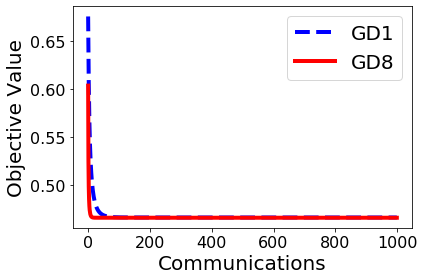

In [233]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4))

communications_gd1 = range(len(gd_1))
communications_gd8 = range(len(gd_8))


line0, = plt.plot(communications_gd1, gd_1, '--b', LineWidth=4)
line1, = plt.plot(communications_gd8, gd_8, '-r', LineWidth=4)


plt.xlabel('Communications', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD1', 'GD8'], fontsize=20)
plt.tight_layout()
plt.show()

## 2.2. Worker Node - SGD

In [217]:
class worker_sgd:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.s = x.shape[0] #number of samples
        self.d = x.shape[1] #number of features
        self.w = numpy.zeros((d,1))
        self.objval = 0
    
    def set_param(self, w):
        self.w = w
    
    def stochastic_gradient_descent(self, q, alpha):
        self.objval = 0
        for i in range(q):
            rand_indices = numpy.random.permutation(self.s)
            x_rand = self.x[rand_indices, :]
            y_rand = self.y[rand_indices, :]
            for k in range(self.s):
                xi = x_rand[k,:]
                yi = float(y_rand[k, :])
                yx = yi * xi # 1-by-d matrix
                yxw = float(numpy.dot(yx, self.w)) # scalar
                loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
                self.objval += loss
                g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
                g = g_loss + lam * self.w # d-by-1 matrix
                self.w -= alpha*g
                alpha *= 0.9
            
        return self.objval
    
    def ascending(self,w):
        p = w-self.w
        return p
 

In [218]:
class Server_sgd:
    def __init__(self,m,n,d):
        self.m = m
        self.n = n
        self.d = d
        self.w = numpy.zeros((d,1))
        self.p = numpy.zeros((d,1))
        self.loss = 0
        self.obj = 0
        
    def broadcast(self):
        return self.w
    
    def aggregate(self, pt, losses):
        self.p = numpy.zeros((self.d,1))
        self.loss=0
        for k in range(self.m):
            self.p += pt[k]
            self.loss += losses[k]
        return self.p
        
    def objective(self, lam,q):
        reg = lam/2*numpy.sum(self.w*self.w)
        self.obj = self.loss/(q*self.n) + reg
        return self.obj
    
    def gd(self, alpha):
        self.p = self.p/self.m
        self.w -= alpha*self.p
        return self.w

In [219]:
def create_server_workers_sgd(m,x,y):
    n,d = x.shape
    s = math.floor(n/m)
    server = Server_sgd(m,n,d)
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        worker = worker_sgd(x[indices,:], y[indices,:])
        workers.append(worker)
    return server, workers

In [220]:
m = 4
server, workers = create_server_workers_sgd(m, x_train, y_train)

In [221]:
lam = 1e-6
alpha = 1e-1
q = 1
communications = 1000
sgd_1 = []
w = server.broadcast()

for i in range(communications):
    for i in range(m):
        workers[i].set_param(w)

    pt = []
    losses = []
    for i in range(m):
        l = workers[i].stochastic_gradient_descent(q, alpha)
        losses.append(l)
        p = workers[i].ascending(w)
        pt.append(p)
        
    p = server.aggregate(pt, losses)
    obj = server.objective(lam,q)
    sgd_1.append(obj)
    w = server.gd(alpha)
    

In [223]:
m = 4
server, workers = create_server_workers_sgd(m, x_train, y_train)

In [224]:
lam = 1e-6
alpha = 1e-1
q = 8
communications = 1000
sgd_8 = []
w = server.broadcast()

for i in range(communications):
    for i in range(m):
        workers[i].set_param(w)

    pt = []
    losses = []
    for i in range(m):
        l = workers[i].stochastic_gradient_descent(q, alpha)
        losses.append(l)
        p = workers[i].ascending(w)
        pt.append(p)
        
    p = server.aggregate(pt, losses)
    obj = server.objective(lam,q)
    sgd_8.append(obj)
    
    w = server.gd(alpha)

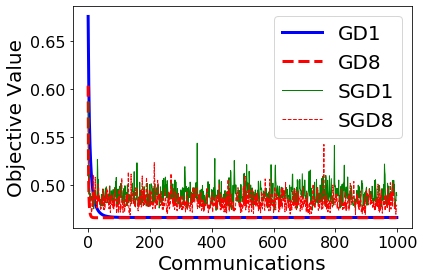

In [234]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4))

communications_gd1 = range(len(gd_1))
communications_gd8 = range(len(gd_8))
communications_sgd1 = range(len(sgd_1))
communications_sgd8 = range(len(sgd_8))


line0, = plt.plot(communications_gd1, gd_1, '-b', LineWidth=3)
line1, = plt.plot(communications_gd8, gd_8, '--r', LineWidth=3)
line2, = plt.plot(communications_sgd1, sgd_1, '-g', LineWidth=1)
line3, = plt.plot(communications_sgd8, sgd_8, '--r', LineWidth=1)


plt.xlabel('Communications', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1,line2, line3], ['GD1', 'GD8', 'SGD1', 'SGD8'], fontsize=20)
plt.tight_layout()
plt.show()